In [1]:
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from pandas import set_option
import pandas as pd
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM
import numpy as np 
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn 
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras import regularizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Flatten, Conv1D

from tensorflow.keras.layers import Dropout
#from tensorflow.keras.constraints import maxnorm
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

import tensorflow as tf
import time as tm
import datetime
import os
from operator import itemgetter
from numpy import argmax

In [2]:
set_option("display.max_rows", 15)
pd.options.mode.chained_assignment = None

# training set is composed by databases: Repbase, RepetDB, and PGSB (consensus)
#filename = '../InpactorDB/InpactorDB_training.fasta.kmer2' 
filename = '../InpactorDB/InpactorDB_training.fasta.kmer2'
training_data = pd.read_csv(filename)
training_data

#dev and test set is composed by LTR_STRUCT database (consensus)
filename = '../InpactorDB/InpactorDB_LTR_STRUCT.fasta.kmers'
dev_test_data = pd.read_csv(filename)

In [3]:
path_log_base = './logs'
# class dist|ribution
print(training_data.groupby('Label').size())

Label
1     2330
3      404
4      403
8       22
9     1244
12    1188
13    1299
14     608
16      90
17    1494
18    2451
19    1092
20    5517
dtype: int64


In [4]:
label_vectors = training_data['Label'].values
feature_vectors = training_data.drop(['Label'], axis=1).values

label_dev_test = dev_test_data['Label'].values
feature_dev_test = dev_test_data.drop(['Label'], axis=1).values

label_vectors
feature_vectors

array([[1363,  953,  836, ...,    1,    1,    1],
       [1024,  611,  718, ...,    0,    4,    1],
       [1407, 1022,  879, ...,    2,    4,    1],
       ...,
       [1078,  925,  795, ...,    2,    1,    1],
       [1385, 1308, 1099, ...,    3,    0,    3],
       [3047, 2018, 2206, ...,   16,   20,   21]])

In [5]:
# Scaling
scaler = preprocessing.StandardScaler().fit(feature_vectors)
feature_vectors_scaler = scaler.transform(feature_vectors)

dev_test_scaler = scaler.transform(feature_dev_test)
#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
#X_trainScaler, X_test_dev, Y_trainScaler, Y_test_dev = train_test_split(feature_vectors_scaler, label_vectors, 
                                                                                        #test_size=validation_size, 

                                                                                     #random_state=seed)

#Split data using training and dev-test sets separately option 1 (training alone and dev-test sets)

X_trainScaler = feature_vectors_scaler
Y_trainScaler = label_vectors

X_dev, X_test, Y_dev, Y_test = train_test_split(dev_test_scaler, label_dev_test, test_size=0.5, random_state=seed)

# Split data using training and dev-test sets separately option 2 (training and train-dev, and test alone)
"""X_trainScaler, X_dev, Y_trainScaler, Y_dev = train_test_split(feature_vectors_scaler, label_vectors, test_size=validation_size, random_state=seed)

X_test = dev_test_scaler
Y_test = label_dev_test"""



'X_trainScaler, X_dev, Y_trainScaler, Y_dev = train_test_split(feature_vectors_scaler, label_vectors, test_size=validation_size, random_state=seed)\n\nX_test = dev_test_scaler\nY_test = label_dev_test'

In [6]:
pca = decomposition.PCA(n_components=0.96,svd_solver='full',tol=1e-4)
pca.fit(X_trainScaler)
X_trainPCAScaler = pca.transform(X_trainScaler)
X_validationPCAScaler = pca.transform(X_dev)
X_testPCAScaler = pca.transform(X_test)

In [7]:
print(len(X_trainPCAScaler[0]))
print(X_trainPCAScaler.shape)

1902
(18142, 1902)


In [8]:
################################################## TLU ACTIVATION FUNCTION
T3 = 3;
def Tanh3(x):
    tanh3 = K.tanh(x)*T3
    return tanh3
##################################################

In [9]:
def metrics(Y_validation,predictions):
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creamos la matriz de confusión
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Visualizamos la matriz de confusión
    snn_df_cm = pd.DataFrame(snn_cm, range(13), range(13))  
    plt.figure(figsize = (20,14))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show()

In [10]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Test Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Train Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['val_accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Validation Accuracy {}, Época:{}\n".format(value, index+1))

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #Plot training & validation accuracy values
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['accuracy'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_accuracy'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.title('Accuracy Vs Epoch')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.pdf', format='pdf')     
        #plt.show()
        
        plt.figure(figsize=(10, 10))
        #Plot training & validation loss values
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
        plt.show() 

In [11]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'Tanh3':Tanh3})
            loss,accuracy = model.evaluate(X_testPCAScaler, one_hot_labels_test,verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [12]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_accuracy:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    
    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [13]:
def InpactorFNN_Net():
    tf.keras.backend.clear_session()

    #Inputs
    inputs = tf.keras.Input(shape=(X_trainPCAScaler.shape[1],), name="input_1")
    #layer 1
    layers = tf.keras.layers.Dense(500,activation="relu", kernel_regularizer=regularizers.l1_l2(l1=0.00001, l2=0))(inputs)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.8, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #layer 2
    layers = tf.keras.layers.Dense(500,activation="relu", kernel_regularizer=regularizers.l1_l2(l1=0.00001, l2=0))(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.8, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #layer 3
    layers = tf.keras.layers.Dense(500,activation="relu", kernel_regularizer=regularizers.l1_l2(l1=0.00001, l2=0))(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.8, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #layer 4
    layers = tf.keras.layers.Dense(500,activation="relu", kernel_regularizer=regularizers.l1_l2(l1=0.00001, l2=0))(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.8, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #layer 5
    layers = tf.keras.layers.Dense(500,activation="relu", kernel_regularizer=regularizers.l1_l2(l1=0.00001, l2=0))(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.8, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #layer 6
    layers = tf.keras.layers.Dense(500,activation="relu", kernel_regularizer=regularizers.l1_l2(l1=0.00001, l2=0))(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.8, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #layer 7
    layers = tf.keras.layers.Dense(500,activation="relu", kernel_regularizer=regularizers.l1_l2(l1=0.00001, l2=0))(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.8, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    # output
    predictions = tf.keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(lr=0.0008, beta_1=0.7, beta_2=0.9, epsilon=1e-07)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    #model.compile(loss=loss_fn, optimizer=opt, metrics=['acc', 'AUC', 'mse','mae','mape'])
    model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
    return model


In [ ]:
def Nakano_Net():
    tf.keras.backend.clear_session()

    # FNN implemented by Nakano

    #Inputs
    inputs = tf.keras.Input(shape=(X_trainPCAScaler.shape[1],), name="input_1")
    #layer 1
    layers = tf.keras.layers.Dense(200,activation="relu")(inputs)
    layers = tf.keras.layers.Dropout(0.5)(layers)
    #layer 2
    layers = tf.keras.layers.Dense(200,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.5)(layers)
    #layer 3
    layers = tf.keras.layers.Dense(200,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.5)(layers)
    # layer 4
    predictions = tf.keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    #model.compile(loss=loss_fn, optimizer=opt, metrics=['acc', 'AUC', 'mse','mae','mape'])
    model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
    return model


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1902)]            0         
_________________________________________________________________
dense (Dense)                (None, 500)               951500    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 500)               1500      
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               1500  

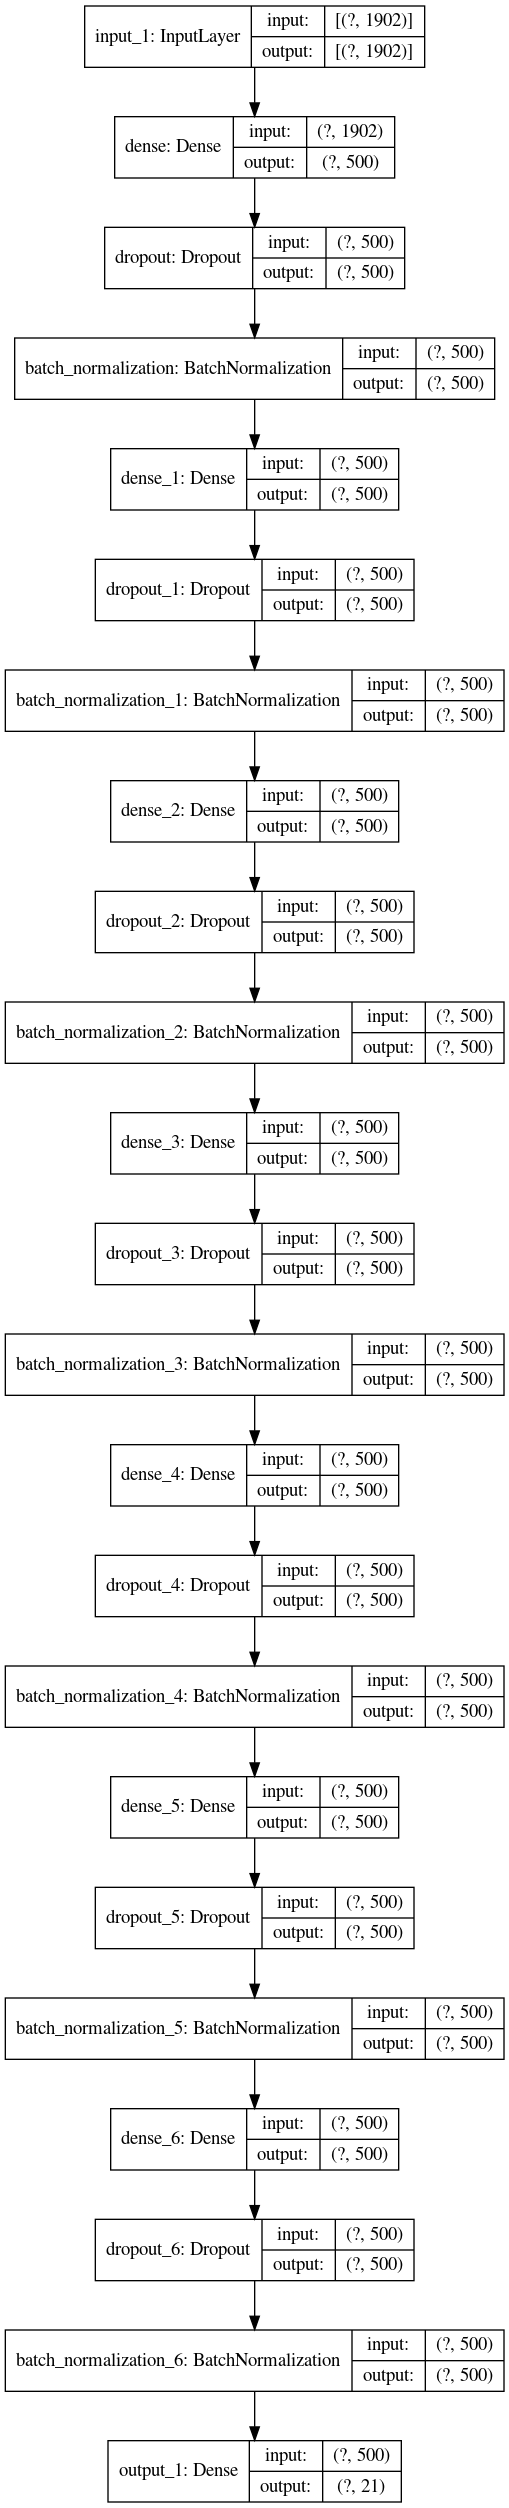

In [14]:
# linea base, arquitectura de Nakano
# model = InpactorFNN_Net()

# arquitectura a afinar
model = InpactorFNN_Net()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
one_hot_labels_train = tf.keras.utils.to_categorical(Y_trainScaler, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
train(model, X_trainPCAScaler, one_hot_labels_train, X_validationPCAScaler, one_hot_labels_validation, X_testPCAScaler, one_hot_labels_test, 56, 200, "InpactorFNN_Net")
Final_Results_Test(log_Dir) 

Epoch 1/200
324/324 [==============================] - 2s 8ms/step - loss: 2.3471 - accuracy: 0.5439 - val_loss: 2.0180 - val_accuracy: 0.6498
Epoch 2/200
324/324 [==============================] - 2s 8ms/step - loss: 1.2538 - accuracy: 0.8763 - val_loss: 1.7515 - val_accuracy: 0.7519
Epoch 3/200
324/324 [==============================] - 2s 8ms/step - loss: 1.0346 - accuracy: 0.9411 - val_loss: 1.6998 - val_accuracy: 0.7759
Epoch 4/200
324/324 [==============================] - 2s 8ms/step - loss: 0.9448 - accuracy: 0.9602 - val_loss: 1.6688 - val_accuracy: 0.7897
Epoch 5/200
275/324 [========================>.....] - ETA: 0s - loss: 0.8817 - accuracy: 0.9664

KeyboardInterrupt: 

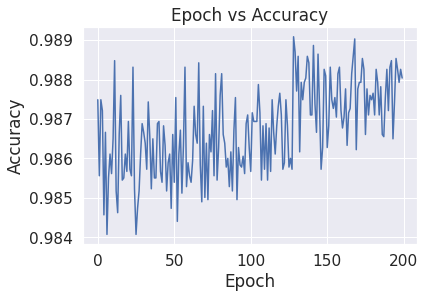

Test Accuracy 0.8520195484161377, Época:183

Test Accuracy 0.8474922180175781, Época:119

Test Accuracy 0.8469595909118652, Época:157

Test Accuracy 0.8450954556465149, Época:107

Test Accuracy 0.8439413905143738, Época:189

Test Accuracy 0.8435863256454468, Época:127

Test Accuracy 0.842521071434021, Época:177

Test Accuracy 0.8423435688018799, Época:38

Test Accuracy 0.8416333794593811, Época:187

Test Accuracy 0.8402130603790283, Época:98


Train Accuracy 0.9890860915184021, Época:129

Train Accuracy 0.9890309572219849, Época:169

Train Accuracy 0.9888656139373779, Época:142

Train Accuracy 0.988700270652771, Época:130

Train Accuracy 0.9886451363563538, Época:145

Train Accuracy 0.9885900020599365, Época:132

Train Accuracy 0.9885900020599365, Época:138

Train Accuracy 0.9885900020599365, Época:168

Train Accuracy 0.9885348677635193, Época:174

Train Accuracy 0.9885348677635193, Época:196


Validation Accuracy 0.8498002886772156, Época:183

Validation Accuracy 0.8441189527511597, É

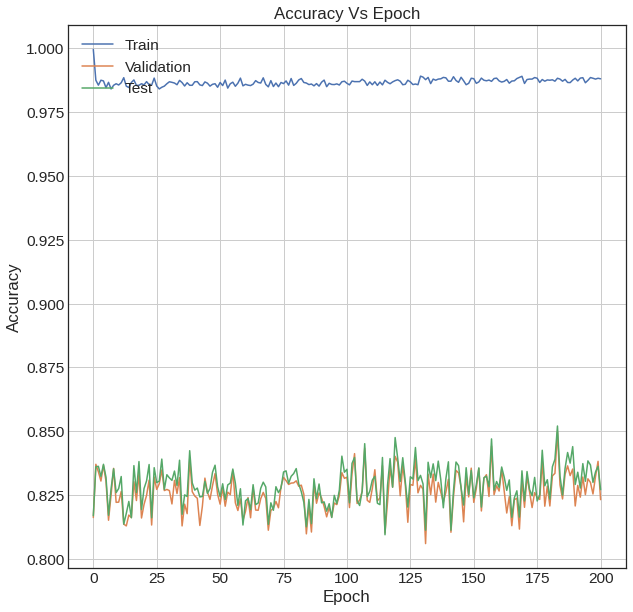

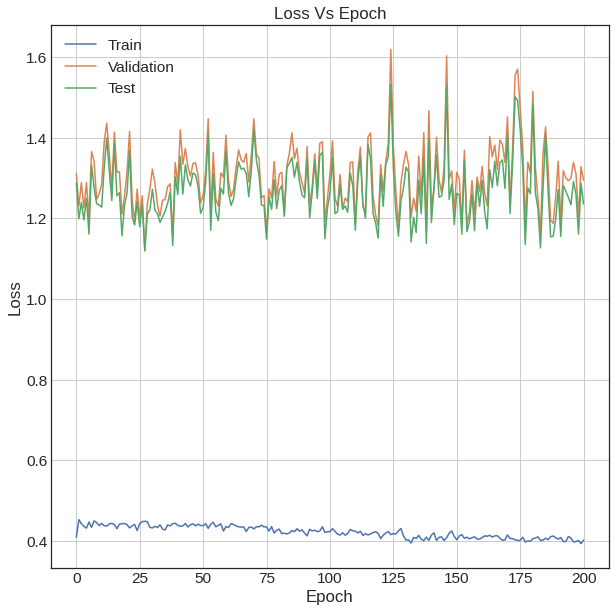

In [21]:
# plot metrics
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)


Baseline Error train: 0.03%
Baseline Error dev: 17.68%
Baseline Error test: 17.29%
Accuracy: 0.9997243964281777
F1 score: 0.9997243334556
Recall: 0.9997243964281777
Precision: 0.9997245537345787

 clasification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      2330
           3       1.00      1.00      1.00       404
           4       1.00      1.00      1.00       403
           8       1.00      1.00      1.00        22
           9       1.00      1.00      1.00      1244
          12       1.00      1.00      1.00      1188
          13       1.00      1.00      1.00      1299
          14       1.00      1.00      1.00       608
          16       1.00      1.00      1.00        90
          17       1.00      1.00      1.00      1494
          18       1.00      1.00      1.00      2451
          19       1.00      1.00      1.00      1092
          20       1.00      1.00      1.00      5517

    accuracy          

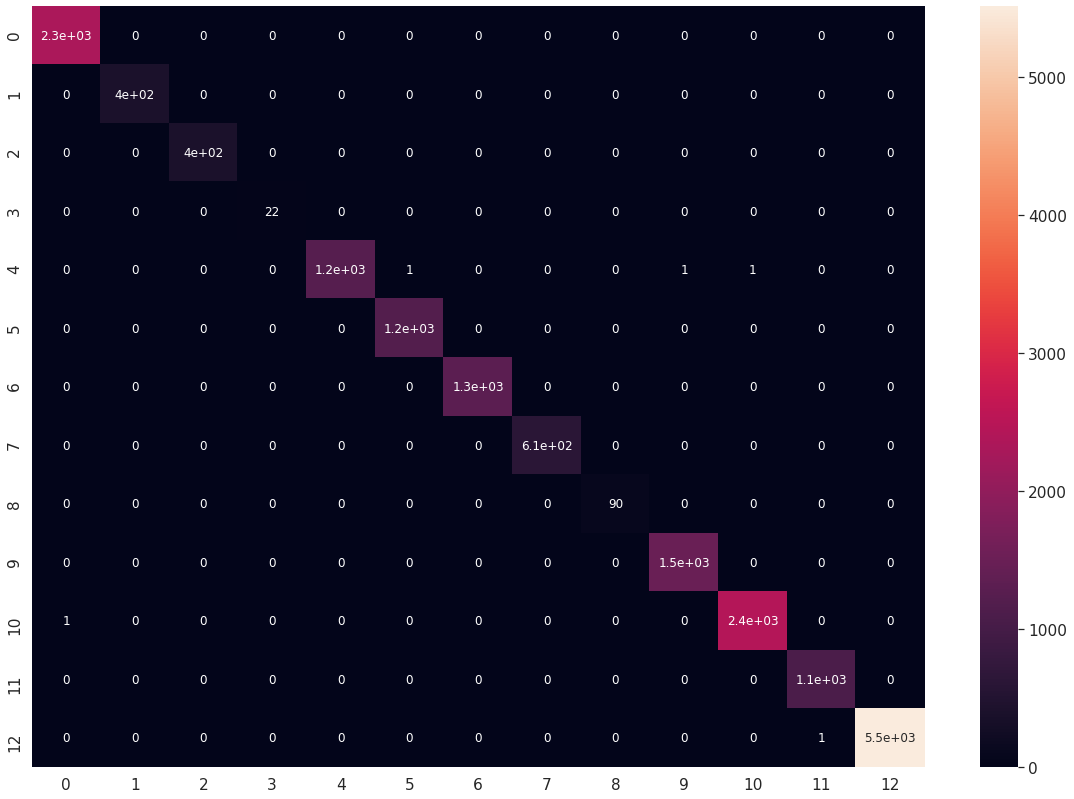

Accuracy: 0.8231691078561918
F1 score: 0.8179597220335947
Recall: 0.8231691078561918
Precision: 0.8307812995252349

 clasification report:
               precision    recall  f1-score   support

           1       0.70      0.82      0.76      1709
           3       0.93      0.58      0.71       198
           4       0.70      0.94      0.80       153
           8       0.75      0.16      0.26        19
           9       0.89      0.55      0.68       622
          12       0.73      0.72      0.73      1177
          13       0.88      0.69      0.77       521
          14       0.88      0.51      0.64       465
          16       0.97      0.32      0.48       106
          17       0.81      0.82      0.81       819
          18       0.85      0.95      0.90      1652
          19       0.71      0.79      0.75       717
          20       0.93      0.96      0.95      3107

    accuracy                           0.82     11265
   macro avg       0.83      0.68      0.71     

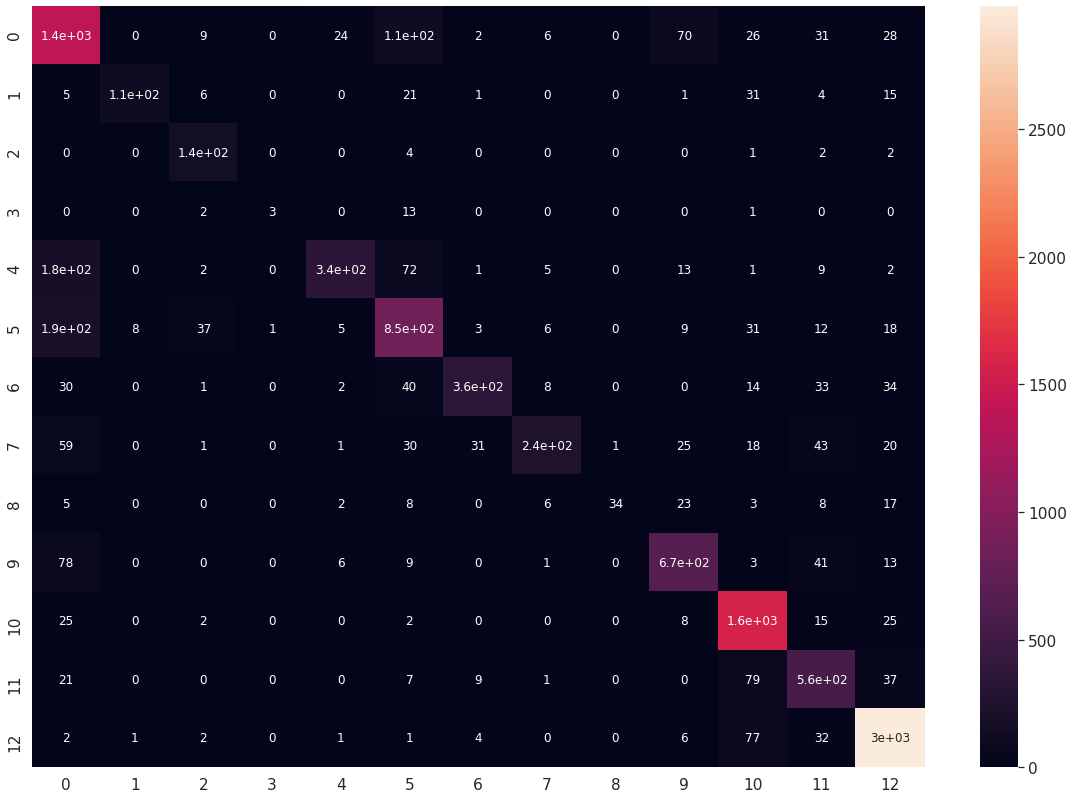

Accuracy: 0.827075011096316
F1 score: 0.823465459029252
Recall: 0.827075011096316
Precision: 0.8362462287018216

 clasification report:
               precision    recall  f1-score   support

           1       0.72      0.81      0.76      1738
           3       0.97      0.61      0.75       228
           4       0.73      0.94      0.82       180
           8       1.00      0.19      0.32        16
           9       0.89      0.56      0.69       590
          12       0.73      0.76      0.75      1152
          13       0.92      0.73      0.81       531
          14       0.91      0.53      0.67       469
          16       1.00      0.44      0.61        96
          17       0.82      0.80      0.81       810
          18       0.82      0.95      0.88      1596
          19       0.69      0.77      0.73       702
          20       0.94      0.96      0.95      3157

    accuracy                           0.83     11265
   macro avg       0.86      0.70      0.73     112

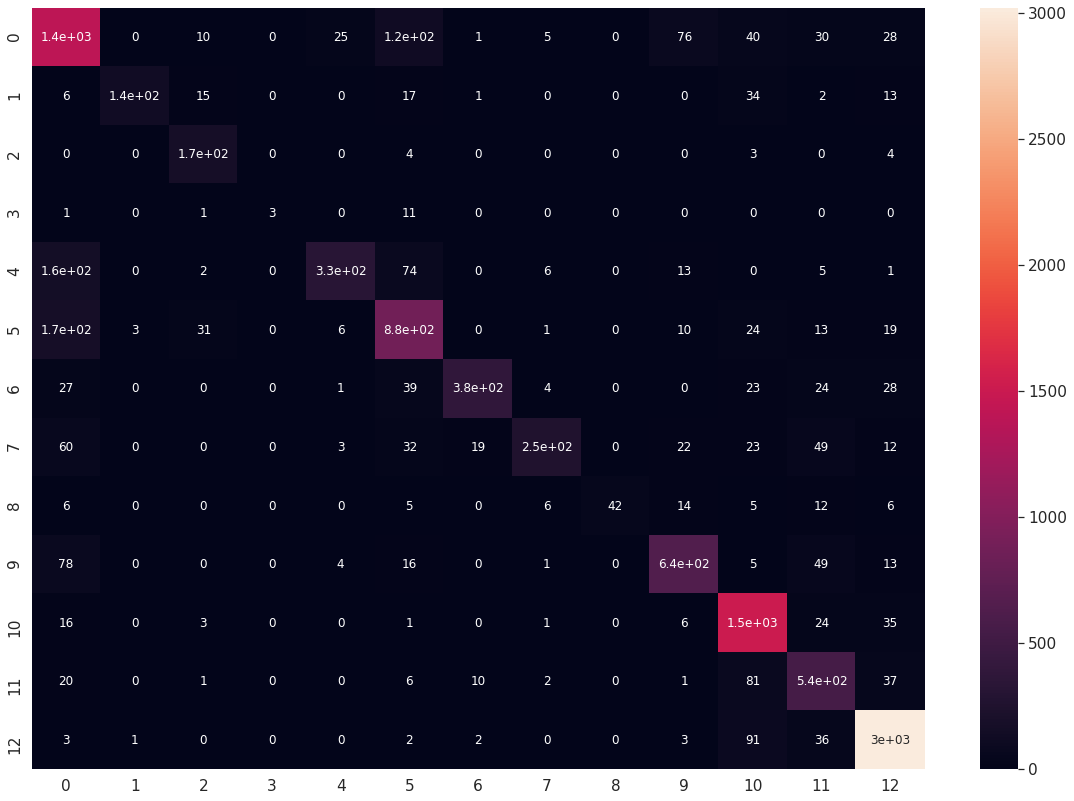

In [22]:
scores = model.evaluate(X_trainPCAScaler, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_validationPCAScaler, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_testPCAScaler, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_trainPCAScaler)

metrics(Y_trainScaler, [argmax(x) for x in predictions])

predictions = model.predict(X_validationPCAScaler)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_testPCAScaler)

metrics(Y_test, [argmax(x) for x in predictions])